In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import splitfolders
import cv2
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models
import os
import random
from PIL import Image

In [3]:
# Split the images in the kaggle dataset into 3 different subfolders
input_folder = "/Users/zhoujingchun/Desktop/Faces"
output_folder = "/Users/zhoujingchun/Desktop/DeepfakeRecognition"

split_ratio = (0.8, 0.1, 0.1)

splitfolders.ratio(
    input_folder, 
    output = output_folder,
    seed = 500,
    ratio = split_ratio,
    group_prefix = None
)

Copying files: 2041 files [00:01, 1468.06 files/s]


In [5]:
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

In [7]:
# Data augmentation (rescale)
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
valid_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [9]:
# Data augmentation (rescale)
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
valid_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [11]:
train_dir = os.path.join(output_folder, 'train')
val_dir = os.path.join(output_folder, 'val')
test_dir = os.path.join(output_folder, 'test')

train_data = train_datagen.flow_from_directory(
    train_dir, 
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical'
)

valid_data = valid_datagen.flow_from_directory(
    val_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 1632 images belonging to 2 classes.
Found 204 images belonging to 2 classes.
Found 205 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


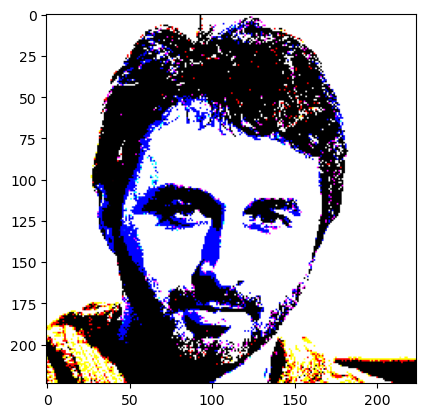

In [69]:
# Print random img
images, labels = next(valid_data)
i = random.randint(0, images.shape[0] - 1)

plt.imshow(images[i])
plt.show()

In [15]:
from keras.applications.resnet import ResNet50
base_model = ResNet50(
    weights = 'imagenet',
    include_top = False,
    input_shape = (img_size[0], img_size[1], 3)
)

base_model.trainable = False

In [23]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation = 'softmax')
])

model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [41]:
# Training for 100 epochs
model.fit(
    train_data, 
    epochs = 100, 
    validation_data = valid_data
)

Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.6767 - loss: 0.5917 - val_accuracy: 0.5931 - val_loss: 0.6775
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.6706 - loss: 0.6068 - val_accuracy: 0.5833 - val_loss: 0.6487
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.6888 - loss: 0.5787 - val_accuracy: 0.6029 - val_loss: 0.6419
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.6412 - loss: 0.6161 - val_accuracy: 0.5686 - val_loss: 0.7052
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.7063 - loss: 0.5755 - val_accuracy: 0.5980 - val_loss: 0.6665
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.6986 - loss: 0.5743 - val_accuracy: 0.5735 - val_loss: 0.7180
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.7042 - loss: 0.5683 - val_accuracy: 0.5735 - val_loss: 0.6623
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.6917 - loss: 0.5841 - val_accuracy: 0.6078 - v

In [43]:
# Evaluate overall accuracy
test_loss, test_accuracy = model.evaluate(test_data)
print(f'Test Accuracy: {test_accuracy * 100: .2f}%')

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 816ms/step - accuracy: 0.6322 - loss: 0.7711
Test Accuracy:  61.46%


In [45]:
class_names = {
    0: 'Fake',
    1: 'Real'
}

In [63]:
def predict_img(image, model):
    test_img = cv2.imread(image)
    test_img = cv2.resize(test_img, (224, 224))
    test_img = np.expand_dims(test_img, axis = 0)
    result = model.predict(test_img)
    r = np.argmax(result)
    if r :
        return 'This photo is real.'
    return 'Watch out! This photo is a fake!'

def detector(img):
    imgArray = np.array(Image.open(img))
    plt.imshow(imgArray)
    plt.show()
    return predict_img(img, model)

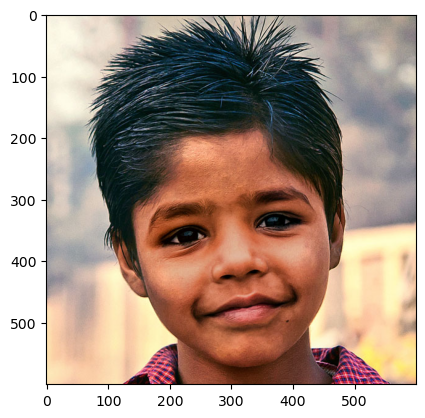

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


'Watch out! This photo is a fake!'

In [65]:
testImg = '/Users/zhoujingchun/Desktop/DeepfakeRecognition/test/fake/mid_364_1111.jpg'
detector(testImg)

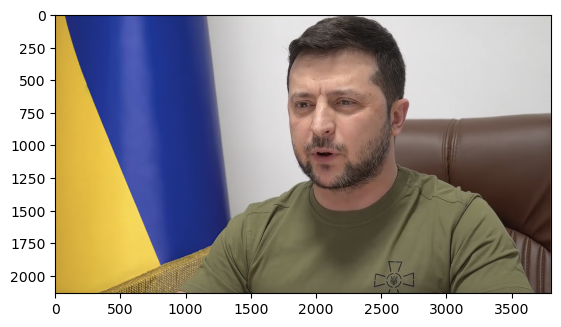

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


'Watch out! This photo is a fake!'

In [75]:
img1 = '/Users/zhoujingchun/Desktop/zelenskyy.jpg'
detector(img1)